# 4.21 Chandrasekharova mez

### 1) Matematická formulace problému
    
<p style="text-align: justify"> 
Najděte radiální profil hustoty bílého trpaslíka, závislost jeho poloměru na hmotnosti a kritickou hmotnost bílých trpaslíků (Chandrasekharovu mez).
</p>    

<p style="text-align: justify"> 
Hustota všech částic (elektronů, protonů a neutronů) je stejná. Hustota hmoty je pak $\rho(r) = 2 m_p n(r)$, kde $m_p$ je hmotnost protonu. Pro hmotnost platí diferenciální rovnice
</p>

$$ \frac{\mathrm{d}m}{\mathrm{d}r} = 4 \pi r^2 \rho.$$

<p style="text-align: justify"> 
Pro hustotu hmoty platí diferenciální rovnice
</p>

$$\frac{\mathrm{d}\rho}{\mathrm{d}r} = - 2 m_p \chi \frac{G m \rho}{r^2},$$

<p style="text-align: justify"> 
kde $\chi$ je kompresibilita elektronové degenerovaného plynu a pro neinteragující relativistické elektrony platí
</p>

$$\chi = \frac{3}{m_e c^2} \frac{\sqrt{1+x_F^2}}{x_F^2}, \hspace{6mm} \mathrm{kde} \; x_F = \frac{\hbar k_F}{m_e c} = \frac{p_F}{m_e c},$$

<p style="text-align: justify"> 
kde $p_F$ je tzv. <em>Fermiho hybnost</em> - pro ni jsem našel vztah$^{\mathrm{[1]}}$ $p_F = h \left( \frac{3n_e}{8 \pi} \right)^{1/3}$, takže $x_F$ můžeme přepsat do tvaru
</p>

$$x_F = \left( \frac{3}{16 \pi m_p} \right)^{1/3} \frac{h}{m_e c} \rho^{1/3}.$$

<p style="text-align: justify"> 
Při výpočtu použijte počáteční podmínky $\rho(0) = \rho_0$, $m(0) = 0$ a pro různé hustoty v rozsahu $10^6-10^{16}\,$kg$\,$m$^{-3}$ nalezněte poloměr bílého trpaslíka $R$ a jeho hmotnost $M$.
</p>

$^{\mathrm{[1]}}$ http://www.fisica.edu.uy/~sbruzzone/FlexPaper_1.4.2_flash/prueba.pdf

### 2) Popis použité numerické metody

<p style="text-align: justify"> 
Pro integraci byla použita metoda <em>Runge-Kutta 4</em>. Použil jsem přímo váš kód ze cvičení. Porovnával jsem to i s funkcí <em>odeint</em> z knihovny <em>scipy</em>, ale pomocí této funkce to bohužel občas dost divergovalo a také jsem dokonce dostal při každém spuštění jiné řešení.
</p>

<p style="text-align: justify"> 
Při této integraci se postupuje po krocích o velikosti $h$ a pro dva následující integrační body (v našem případě se jedná o vzdálenosti) platí: $t_{\mathrm{n}+1} = t_{\mathrm{n}} + h$.
</p>


<p style="text-align: justify"> 
Výsledná funkční hodnota je aproximována pomocí 4 koeficientů:
</p>

$k_1 = h \; f ( x_{\mathrm{n}}, t_{\mathrm{n}} )$,\
$k_2 = h \; f ( x_{\mathrm{n}} + \frac{1}{2} k_1, t_{\mathrm{n}} + \frac{1}{2} h )$,\
$k_3 = h \; f ( x_{\mathrm{n}} + \frac{1}{2} k_2, t_{\mathrm{n}} + \frac{1}{2} h )$ a\
$k_4 = h \; f ( x_{\mathrm{n}} + k_3, t_{\mathrm{n}} + h ),$

<p style="text-align: justify"> 
kde $f (x_{\mathrm{n}}, t_{\mathrm{n}})$ je první derivace funkce vyčíslená v bodech $x_{\mathrm{n}}$ a $t_{\mathrm{n}}$. Koeficient $k_1$ odpovídá koeficintu z Eulerovy metody, ostatní koeficienty slouží ke zpřesnění výpočtu funkční hodnoty pomocí polovičního časového (v našem případě délkového) kroku $\frac{h}{2}$ případně koeficientů z něj vycházejících. Pro výslednou funkční hodnotu $x_{\mathrm{n}+1}$ v bodě $t_{\mathrm{n}+1}$ platí:
</p>

$$x_{\mathrm{n}+1} = x_{\mathrm{n}} + h \frac{1}{6} \left( k_1 + 2 \, k_2 + 2 \, k_3 + k_4 \right) .$$

In [1]:
# zdrojový kód použité numerické metody
def dsolve_RungeKutta4(f,x0,t):
    N=x0.shape[0]
    Nt=t.shape[0]
    x=zeros((Nt,N))
    x[0,:]=x0

    for j in range(Nt-1):
        h=t[j+1]-t[j]
        k1=h*array(f(x[j,:],t[j]))
        k2=h*array(f(x[j,:]+k1/2,t[j]+h/2))
        k3=h*array(f(x[j,:]+k2/2,t[j]+h/2))
        k4=h*array(f(x[j,:]+k3,t[j]+h))
        x[j+1,:]=x[j,:]+(k1+2*k2+2*k3+k4)/6
    return x

### 3), 4) Okomentovaný zdrojový kód programu, Výsledky v grafické podobě

In [4]:
import matplotlib.pyplot as plt
from math import isnan
from numpy import array, linspace, logspace, log10, pi, sqrt, zeros
from scipy import integrate
from scipy.constants import m_e, m_p, c, h, hbar, G
from sunpy.sun.constants import mass as Ms
from sunpy.sun.constants import radius as Rs
Ms, Rs = Ms.value, Rs.value
rhos = Ms / (4/3*pi*Rs**3)
%matplotlib inline

In [5]:
# fce vrací vektor obsahující obě diferenciální rovnice
def dx_dr(X, r):
    x_F = X[1]**(1/3) * (3/(16*pi*m_p))**(1/3) * h / (m_e * c)
    Chi = 3 / (m_e*c**2) * sqrt(1 + x_F**2) * x_F**(-2)
    return array([4*pi*r**2*X[1], -2*m_p*Chi*G/r**(2)*X[0]*X[1]])

# fce generující graf závislosti hustoty a hmotnosti na vzdálenosti od středu pro dané rho
# parameter r_max byl použit pro hledání vhodných vzdáleností pro oba okrajové případy, viz níže.
def plot(rho, r_max, rg=0):
    m0 = 0
    r = linspace(1, r_max, 100)                # definiční obor poloměru v němž integrujeme
    X0 = array([m0, rho])                      # soubor počátečních podmínek
    if rg:
        X = dsolve_RungeKutta4(dx_dr, X0, r)   # integrace pomocí Runge-Kutty 
    else:
        X = integrate.odeint(dx_dr, X0, r)     # integrace pomocí scipy funkce
    mass, density = X.T
    
    fontsize = 14
    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    plt.title("$\\rho_0$ = {0:.0e} kg/m$^3$".format(rho), size=fontsize+1)
    plt.xticks(fontsize=fontsize-1)
    ax.tick_params(labelsize=fontsize-1)
    ax2.tick_params(labelsize=fontsize-1)
    
    p1 = ax.plot(r/Rs, density/rhos, label="density")
    p2 = ax2.plot(r/Rs, mass/Ms, label="mass", color="C1")
    
    plt.xlim(0, r_max/Rs)
    plt.locator_params(axis='x', nbins=6)
    ax.set_xlabel("Radius [R$_{\odot}$]", size=fontsize)
    ax.set_ylabel("Density [$\\rho_{\odot}$]", size=fontsize)
    ax2.set_ylabel("Mass [M$_{\odot}$]", size=fontsize)
    ax2.legend(p1+p2, ["density", "mass"], loc="center right", prop={'size':fontsize-1})

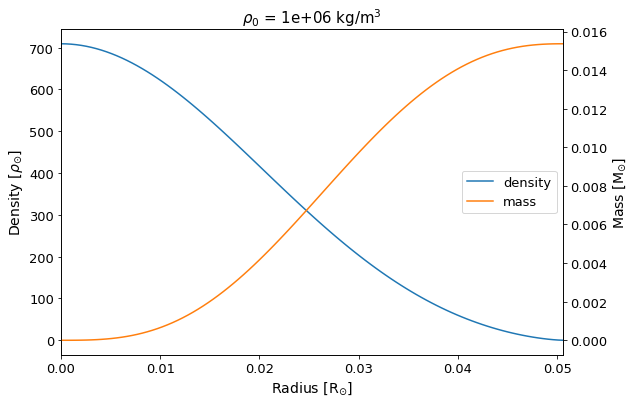

In [6]:
# minimální hustota
plot(1e6, 0.352e8, rg=0)

#### Graf 1a: Radiální průběh hustoty a hmotnosti bílého trpaslíka s centrální hustotou $10^6$ kg$\,$m$^{-3}$.

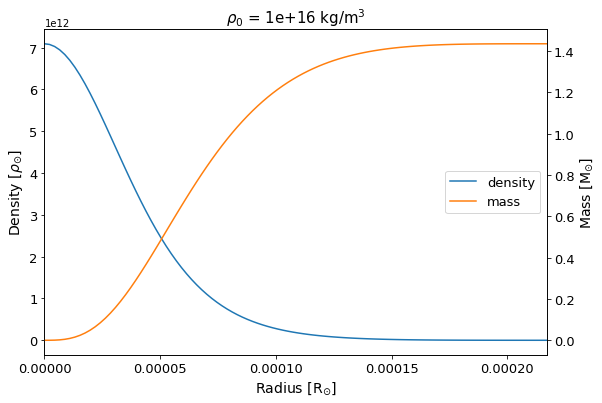

In [7]:
# maximální hustota
plot(1e16, 1.51e5, rg=0)

#### Graf 1b: Radiální průběh hustoty a hmotnosti bílého trpaslíka s centrální hustotou $10^{16}$ kg$\,$m$^{-3}$.

In [15]:
# funkce generující závislost poloměru bílého trpaslíka na jeho hmotnosti
def mass_to_radius(N1, N2, rg=0):
    # N1...hustota definičního oboru poloměru r
    # N2...počet hustotních kroků
    
    m0 = 0
    df_rho = logspace(6, 15, N2)           # definiční obor hustoty
    r_max = linspace(0.356e8, 2e5, N2)     # promněnlivé maximum definičního oboru vzdálenosti

    M, R = [], []
    for rho, r_m in zip(df_rho, r_max):
        r = linspace(1, r_m, N1)           # definiční obor vzdálenosti
        X0 = array([m0, rho])              # počáteční podmínky hmostnosti a hustoty
        if rg:
            X = dsolve_RungeKutta4(dx_dr, X0, r)  # integrace pomocí Runge-Kutty
        else:
            X = integrate.odeint(dx_dr, X0, r)    # integrace pomocí scipy funkce
        mass, density = X.T
        M.append(max(mass)/Ms)
        for i in range(len(r)):
            if isnan(density[i]):          # místo nulové hustoty hledám první "nan"
                R.append(r[i]/Rs)
                break

    Mch = max(M)                           # nejvyšší hmotnost v seznamu je hledaná Chand. mez
    
    fontsize = 14
    plt.figure(figsize=(9,6))
    plt.title("Mass to radius relation for white dwarfs", fontsize=fontsize+1)
    plt.xlim(0, 1.6)
    plt.ylim(0, 3.55e7/Rs)
    plt.xticks(fontsize=fontsize-1)
    plt.yticks(fontsize=fontsize-1)
    plt.xlabel("Mass [M$_{\odot}$]", fontsize=fontsize)
    plt.ylabel("Radius [R$_{\odot}$]", fontsize=fontsize)
    plt.text(x=1.45, y=0.012, s="Chandrasekhar limit = %.3f M$_{\odot}$" % Mch, rotation=90, fontsize=fontsize-1)
    plt.grid()

    plt.plot(M[:-1], R, linewidth=1.8)
    plt.plot([Mch, Mch], [0, 0.052], "--", color="black", linewidth=1.1)
    plt.savefig("M_to_R.png", dpi=90)

/home/plsek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


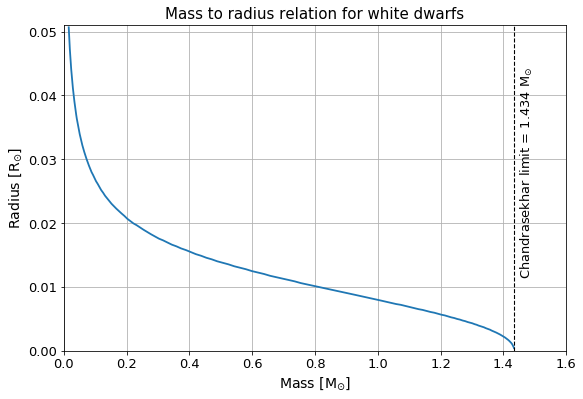

In [16]:
mass_to_radius(500, 200, rg=1)

#### Graf 2: Závislost pomoloměru bílého trpaslíka na jeho celkové hmotnost.

### 5) Závěr

<p style="text-align: justify">
Původně jsem rovnice pro všechny hustoty (df_rho) řešil v rozsahu $r = (0, R_{\odot})$, ukázalo se však, že pro velmi husté/hmotné bílé trpaslíky s velmi malým poloměrem je tento rozsah i nejmenší krok (i při použítí <em>logspace</em>) velmi nevyhovující. Při určování závislosti poloměru na hmotnosti byla proto hodnota $r_{\mathrm{max}}$ extrapolována (lineárně) mezi dvě krajní hodnoty odpovídající hustotám $10^6$ a $10^{16}$ kg$\,$m$^{-3}$ (odpovídající hodnoty jsem lehce nadsadil a pro definiční obor hustoty jsem použil <em>logspace</em> zatímco $r_{\mathrm{max}}$ byla extrapalována lineárně - <em>linspace</em>, čímž jsem zajistil, že $R$ bude v intervalu $(0, r_{\mathrm{max}})$.
</p>

<p style="text-align: justify">
Výsledné závlislosti pro krajní hodnoty centrální hustoty jsou zobrazeny v Grafech 1a a 1b. Hledaná závislost poloměru bílého trpaslíka na jeho celkové hmotnost je znázorněna v Grafu 2. Maximálním hmotnostním limitem je Chandrasekharova mez, což odpovídá přibližně $1.434 \: \mathrm{M}_{\odot}$.
</p>